In [20]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import tifffile
# import numpy as np
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt

# patch_size = 4
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# ########################################
# # VAE Definition (Ancora più profondo per patch 4x4)
# ########################################
# class VAE(nn.Module):
#     def __init__(self, latent_dim=128):
#         super(VAE, self).__init__()
#         # Encoder per patch 4x4
#         # Input: (1,4,4)
#         # Tre step di downsampling:
#         # 4x4 --conv--> 2x2 --conv--> 1x1 con più canali
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1), # 1->16,4x4->2x2
#             nn.ReLU(),
#             nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1), # 16->32,2x2->1x1
#             nn.ReLU(),
#             # Un ulteriore livello conv per aumentare la capacità (anche se 1x1, può aumentare i canali)
#             nn.Conv2d(32,64, kernel_size=1, stride=1), # 32->64,1x1->1x1
#             nn.ReLU()
#         )
#         # Ora abbiamo un feature vector di 64 canali (1x1) = 64 dim
#         self.fc_mu = nn.Linear(64, latent_dim)
#         self.fc_var = nn.Linear(64, latent_dim)

#         # Decoder: da latent_dim a 64, poi gradualmente tornare a 4x4
#         self.fc_decode = nn.Linear(latent_dim, 64)
#         self.decoder = nn.Sequential(
#             # Partiamo da (64,1,1)
#             nn.ConvTranspose2d(64,32, kernel_size=1, stride=1), # 64->32, 1x1->1x1
#             nn.ReLU(),
#             nn.ConvTranspose2d(32,16, kernel_size=3, stride=2, padding=1, output_padding=1), # 32->16,1x1->2x2
#             nn.ReLU(),
#             nn.ConvTranspose2d(16,8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16->8,2x2->4x4
#             nn.ReLU(),
#             nn.Conv2d(8,1,kernel_size=1,stride=1), # Riduzione canali 8->1 su 4x4
#             nn.Sigmoid()
#         )

#     def encode(self, x):
#         h = self.encoder(x) # es: (B,64,1,1)
#         h = h.view(h.size(0), -1) # (B,64)
#         mu = self.fc_mu(h)
#         log_var = self.fc_var(h)
#         return mu, log_var

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h = self.fc_decode(z) # (B,64)
#         h = h.view(h.size(0),64,1,1)
#         recon = self.decoder(h) # (B,1,4,4)
#         return recon

#     def forward(self, x):
#         mu, log_var = self.encode(x)
#         z = self.reparameterize(mu, log_var)
#         recon = self.decode(z)
#         return recon, mu, log_var

# ########################################
# # Dataset su stack2 (UNA SOLA IMMAGINE)
# ########################################
# class StackDataset(Dataset):
#     def __init__(self, stack_path, patch_size=4, num_patches=50000):
#         stack = tifffile.imread(stack_path) # shape (num_layers,H,W)
#         img = stack.mean(axis=0).astype(np.float32) # una sola immagine media
#         max_val = img.max() if img.max()>0 else 1.0
#         img /= max_val
#         self.img = img
#         self.H, self.W = img.shape
#         self.patch_size = patch_size
#         self.coords = []
#         for _ in range(num_patches):
#             y = np.random.randint(0, self.H - patch_size)
#             x = np.random.randint(0, self.W - patch_size)
#             self.coords.append((y,x))
#         self.transform = transforms.ToTensor()

#     def __len__(self):
#         return len(self.coords)

#     def __getitem__(self, idx):
#         y,x = self.coords[idx]
#         patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
#         patch_tensor = self.transform(patch) # (1,4,4)
#         return patch_tensor

# # Carichiamo stack2
# train_dataset = StackDataset("../stacks/stack2.tif", patch_size=patch_size, num_patches=100000)
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# ########################################
# # Training VAE con scheduler ed early stopping
# ########################################
# vae = VAE(latent_dim=128).to(device)
# optimizer = optim.Adam(vae.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# mse_loss = nn.MSELoss()

# epochs = 1000
# best_loss = float('inf')
# patience = 100
# no_improvement_count = 0
# loss_history = []

# for epoch in range(epochs):
#     vae.train()
#     running_loss = 0.0
#     for patches in train_loader:
#         patches = patches.to(device)
#         optimizer.zero_grad()
#         recon, mu, log_var = vae(patches)
#         # loss = MSE + KL
#         recon_loss = mse_loss(recon, patches)
#         kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
#         loss = recon_loss + 0.0001*kl_loss
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     avg_loss = running_loss/len(train_loader)
#     loss_history.append(avg_loss)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

#     scheduler.step()

#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         no_improvement_count = 0
#         torch.save(vae.state_dict(), "best_vae_4x4_deeper.pth")
#         print("Best model saved")
#     else:
#         no_improvement_count += 1
#         if no_improvement_count >= patience:
#             print("Early stopping triggered!")
#             break




In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

patch_size = 4
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

########################################
# VAE Definition (Più profondo per patch 4x4)
########################################
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        # Encoder per patch 4x4
        # Input: (1,4,4)
        # Aumentiamo la complessità dell'encoder:
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1), # 1->16, 4x4 -> 2x2
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1), # 16->32, 2x2->1x1
            nn.ReLU()
        )
        # Ora abbiamo un feature vector di 32 canali 1x1 = 32 dim
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_var = nn.Linear(32, latent_dim)

        # Decoder: da latent_dim a 32, poi ConvTranspose2d per arrivare a 4x4
        self.fc_decode = nn.Linear(latent_dim, 32)
        self.decoder = nn.Sequential(
            # Ora invertiamo le due conv con convtranspose
            nn.ConvTranspose2d(32,16, kernel_size=3, stride=2, padding=1, output_padding=1), # 32->16, 1x1->2x2
            nn.ReLU(),
            nn.ConvTranspose2d(16,1, kernel_size=3, stride=2, padding=1, output_padding=1), # 16->1, 2x2->4x4
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x) # es: (B,32,1,1)
        h = h.view(h.size(0), -1) # (B,32)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z) # (B,32)
        h = h.view(h.size(0),32,1,1)
        recon = self.decoder(h) # (B,1,4,4)
        return recon

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var

########################################
# Dataset su stack2 (UNA SOLA IMMAGINE)
########################################
class StackDataset(Dataset):
    def __init__(self, stack_path, patch_size=4, num_patches=50000):
        stack = tifffile.imread(stack_path) # shape (num_layers,H,W)
        img = stack.mean(axis=0).astype(np.float32) # una sola immagine media
        max_val = img.max() if img.max()>0 else 1.0
        img /= max_val
        self.img = img
        self.H, self.W = img.shape
        self.patch_size = patch_size
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_tensor = self.transform(patch) # (1,4,4)
        return patch_tensor

# Carichiamo stack2
train_dataset = StackDataset("../stacks/stack2.tif", patch_size=patch_size, num_patches=2000)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

########################################
# Training VAE con scheduler ed early stopping
########################################
vae = VAE(latent_dim=64).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
mse_loss = nn.MSELoss()

epochs = 1000
best_loss = float('inf')
patience = 30
no_improvement_count = 0
loss_history = []

for epoch in range(epochs):
    vae.train()
    running_loss = 0.0
    for patches in train_loader:
        patches = patches.to(device)
        optimizer.zero_grad()
        recon, mu, log_var = vae(patches)
        # loss = MSE + KL
        recon_loss = mse_loss(recon, patches)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.0001*kl_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    scheduler.step()

    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improvement_count = 0
        torch.save(vae.state_dict(), "best_vae_4x4.pth")
        print("Best model saved")
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

########################################
# Carichiamo il modello migliore e calcoliamo l'errore su proof/1.png
########################################
vae.load_state_dict(torch.load("best_vae_4x4.pth", map_location=device))
vae.eval()

img_path = "../proof/1.png"
img_input = Image.open(img_path).convert('L')
img_np = np.array(img_input, dtype=np.float32)/255.0
H, W = img_np.shape
to_tensor = transforms.ToTensor()

error_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

with torch.no_grad():
    for y in range(H - patch_size + 1):
        for x in range(W - patch_size + 1):
            patch = img_np[y:y+patch_size, x:x+patch_size]
            patch_tensor = to_tensor(patch).unsqueeze(0).to(device) # (1,1,4,4)
            recon, mu, log_var = vae(patch_tensor)
            recon_np = recon.squeeze(0).cpu().numpy()[0] # (4,4)
            # mse = (patch - recon_np)**2
            mse = np.abs(patch - recon_np)
            error_map[y:y+patch_size, x:x+patch_size] += mse
            count_map[y:y+patch_size, x:x+patch_size] += 1.0

valid = (count_map > 0)
error_map[valid] /= count_map[valid]


Epoch 1/1000, Loss: 0.0511
Best model saved
Epoch 2/1000, Loss: 0.0151
Best model saved
Epoch 3/1000, Loss: 0.0146
Best model saved
Epoch 4/1000, Loss: 0.0144
Best model saved
Epoch 5/1000, Loss: 0.0144
Best model saved
Epoch 6/1000, Loss: 0.0144
Best model saved
Epoch 7/1000, Loss: 0.0143
Best model saved
Epoch 8/1000, Loss: 0.0144
Epoch 9/1000, Loss: 0.0144
Epoch 10/1000, Loss: 0.0144
Epoch 11/1000, Loss: 0.0143
Best model saved
Epoch 12/1000, Loss: 0.0143
Epoch 13/1000, Loss: 0.0143
Epoch 14/1000, Loss: 0.0143
Epoch 15/1000, Loss: 0.0143
Epoch 16/1000, Loss: 0.0144
Epoch 17/1000, Loss: 0.0144
Epoch 18/1000, Loss: 0.0143
Epoch 19/1000, Loss: 0.0144
Epoch 20/1000, Loss: 0.0145
Epoch 21/1000, Loss: 0.0144
Epoch 22/1000, Loss: 0.0143
Epoch 23/1000, Loss: 0.0143
Epoch 24/1000, Loss: 0.0143
Epoch 25/1000, Loss: 0.0143
Epoch 26/1000, Loss: 0.0143
Epoch 27/1000, Loss: 0.0143
Epoch 28/1000, Loss: 0.0143
Epoch 29/1000, Loss: 0.0143
Epoch 30/1000, Loss: 0.0143
Epoch 31/1000, Loss: 0.0143
Epoch

/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_4274/701700815.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae_4x4.

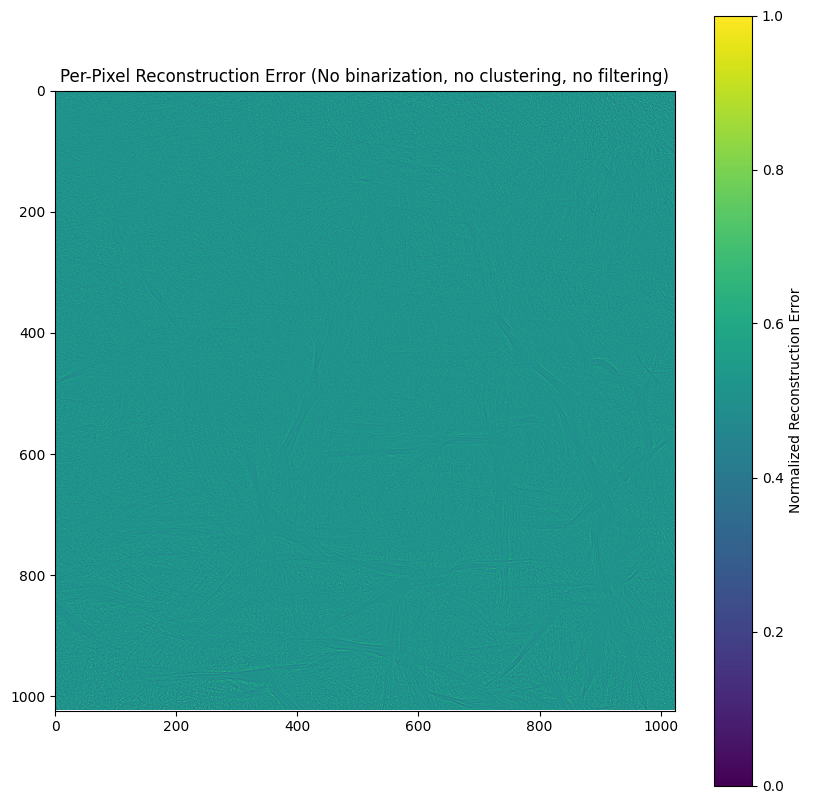

In [51]:
plt.figure(figsize=(10,10))
normalized_error = error_map - error_map.min()
normalized_error /= (normalized_error.max() + 1e-8)
plt.imshow(normalized_error, cmap='viridis', vmin=normalized_error.min(), vmax=normalized_error.max())
plt.colorbar(label='Normalized Reconstruction Error')
plt.title("Per-Pixel Reconstruction Error (No binarization, no clustering, no filtering)")
plt.show()

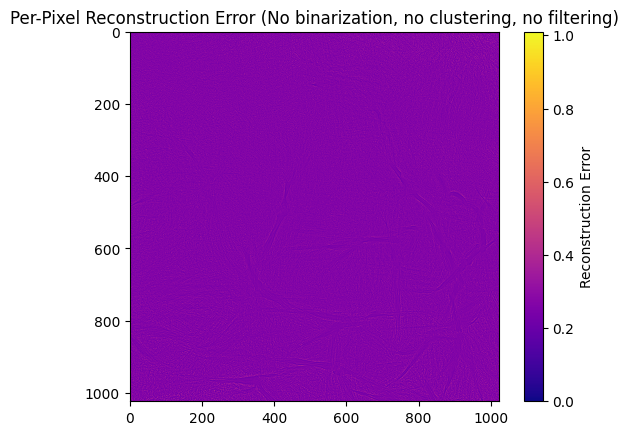

In [42]:
plt.imshow(error_map, cmap='plasma', vmin=error_map.min(), vmax=error_map.max()+0.01)
plt.colorbar(label='Reconstruction Error')
plt.title("Per-Pixel Reconstruction Error (No binarization, no clustering, no filtering)")
plt.show()

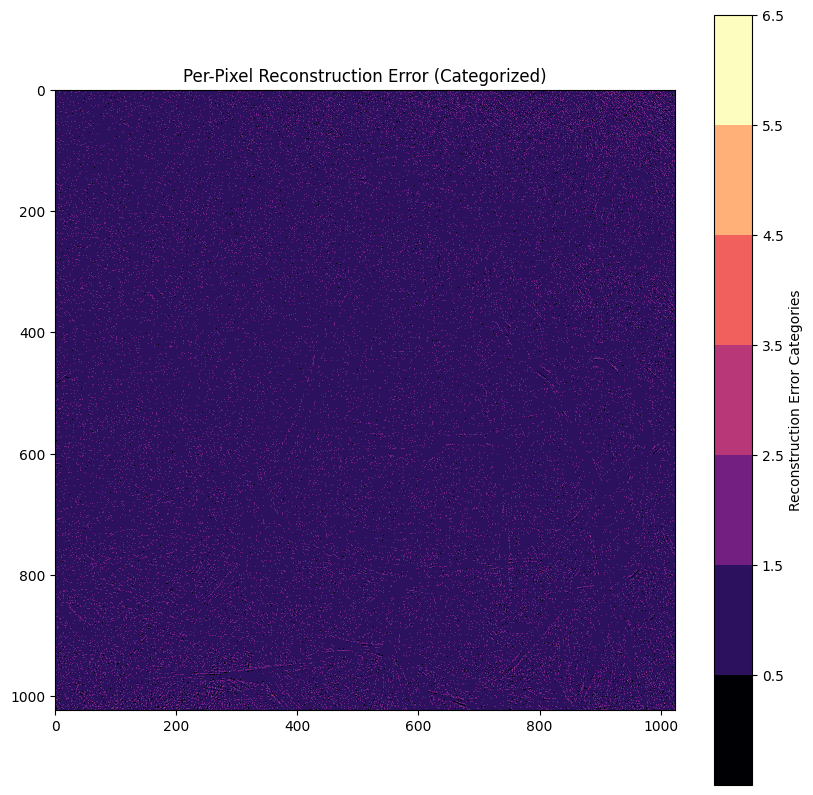

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Creare una mappa scalare con 5 colori distinti
num_colors = 7
colors = plt.cm.magma(np.linspace(0, 1, num_colors))
cmap = ListedColormap(colors)

# Normalizzare i dati
normalized_error = error_map - error_map.min()
normalized_error /= (normalized_error.max() + 1e-8)

# Suddividere i valori in bin
binned_error = np.digitize(normalized_error, bins=np.linspace(0, 1, num_colors + 1)) - 1

# Creare la figura
plt.figure(figsize=(10, 10))
plt.imshow(binned_error, cmap=cmap, vmin=0, vmax=num_colors - 1)
plt.colorbar(
    ticks=np.arange(0, num_colors) + 0.5, 
    label='Reconstruction Error Categories', 
    boundaries=np.arange(-0.5, num_colors + 0.5)
)
plt.title("Per-Pixel Reconstruction Error (Categorized)")
plt.show()
